## 영화 리뷰로부터 감성분석해보기

#### Naver Movie로부터 영화 리뷰 데이터 수집

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
header = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36'}

In [2]:
def getDownload(url, param=None, retries=3):
    resp = None
    try:
        resp = requests.get(url, params=param, headers=header)
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        if 500 <= resp.status_code < 600 and retries > 0:
            print('Retries : {0}'.format(retries))
            return getDownload(url, param, retries - 1)
        else:
            print(resp.status_code)
            print(resp.reason)
            print(resp.request.headers)
    return resp

In [3]:
url = 'https://movie.naver.com/movie/point/af/list.nhn'
params = {'page':1}

html = getDownload(url)
dom = BeautifulSoup(html.text, 'html.parser')

In [5]:
result = list()
for page in range(1, 10+1):
    params['page'] = page
    html = getDownload(url, params)
    dom = BeautifulSoup(html.text, 'html.parser')

    title = [tag.text.split('\n')[1] for tag in dom.select('table.list_netizen td.title')]
    content = [tag.text.split('\n')[2] for tag in dom.select('table.list_netizen td.title')]
    point = [tag.text for tag in dom.select('table.list_netizen td.point')]

    pd_title = pd.DataFrame(title, columns=['제목'])
    pd_content = pd.DataFrame(content, columns=['리뷰'])
    pd_point = pd.DataFrame(point, columns=['평점'])
    pd_result = pd.concat([pd_title, pd_content, pd_point], axis=1)
    
    result.append(pd_result)
    
excel = pd.concat(result)
excel.to_csv('./NaverMovieReview/movie.csv', index=False)

In [6]:
data = pd.read_csv('./NaverMovieReview/movie.csv')
data.head()

,제목,리뷰,평점
0,뽀로로 극장판 보물섬 대모험,애들이 너무나 좋아했어용~~역시 뽀로로는 아이들의 대통령,10
1,왓칭,난 다운받아봤는데 나쁘지않은데~? 끝이 좀 뭐같지만;; ㅋ,6
2,어벤져스: 엔드게임,"와,,,,진짜 마블 ㅎㅎ",10
3,어벤져스: 엔드게임,충분히 좋음..공백 제외,8
4,어벤져스: 엔드게임,3000만큼사랑항.,8


In [7]:
data.count()

제목    100
리뷰    100
평점    100
dtype: int64

In [8]:
data.groupby(["평점"]).count()

,제목,리뷰
평점,,
1,6,6
2,6,6
4,1,1
6,6,6
7,1,1
8,10,10
9,3,3
10,67,67


In [9]:
upperBound = 7
lowerBound = 3

data = data[data["평점"] < 10]
positive = data[data["평점"] > upperBound]
negative = data[data["평점"] < lowerBound]

In [10]:
len(positive), len(negative)

(13, 12)

## 자질 추출(Positive/Negative)

In [11]:
from collections import Counter, defaultdict
from konlpy.tag import Komoran

# DTM만들기
positiveDTM = defaultdict(Counter)
# Positive 1 => {"형태소/품사" = 횟수, "형태소/품사" = 횟수, "형태소/품사" = 횟수, ...}
# Negative 1 => {"형태소/품사" = 횟수, "형태소/품사" = 횟수, "형태소/품사" = 횟수, ...}
negativeDTM = defaultdict(Counter)

ma = Komoran()

for i, review in enumerate(positive["리뷰"]):
    posList = ma.pos(review) # => [[형태소, 품사], ]
    
    for term in posList: # => [형태소, 품사]
        if len(term[0]) > 1:
            positiveDTM[i]["/".join(term)] += 1 # => "형태소/품사"
            
for i, review in enumerate(negative["리뷰"]):
    posList = ma.pos(review)
    
    for term in posList:
        if len(term[0]) > 1:
            negativeDTM[i]["/".join(term)] += 1

In [11]:
# TDM만들기
positiveTDM = defaultdict(Counter)
negativeTDM = defaultdict(Counter)

for i, termList in positiveDTM.items():
    for term, freq in termList.items():
        positiveTDM[term][i] = freq

for i, termList in negativeDTM.items():
    for term, freq in termList.items():
        negativeTDM[term][i] = freq

In [12]:
positiveLexicon = list(set(positiveTDM.keys()))
negativeLexicon = list(set(negativeTDM.keys()))

positiveDocuments = list(positiveDTM.keys())
negativeDocuments = list(negativeDTM.keys())

## 분류별 품사통계

In [13]:
from collections import defaultdict, Counter # defaultdict 두개 중첩하는 대신 Counter 사용. 
# Counter는 defaultdict처럼 돌아가지만 빈도별로 알아서 구성해줌(sorting 불필요). 

positivePOS = defaultdict(Counter)
negativePOS = defaultdict(Counter)

for term in positiveLexicon:
    tokens = term.split("/")
    # "형태소/품사" -> tokens[0]:형태소(ex. 어/벤/저/스), tokens[1]:품사
    # TDM[term] => 어느 문서에서 몇 번, 
    
    positivePOS[tokens[-1]]["".join(tokens[0:-1])] += sum(positiveTDM[term].values())
    # 명사 -> 단어1:positive 내 전체 등장횟수, 단어2:, 단어3:, ...
    # '어/벤/져/스'같은 경우에 대해서도 잘 작동하도록 하기 위함
    
for term in negativeLexicon:
    tokens = term.split("/")
    
    negativePOS[tokens[-1]][tokens[0]] += sum(negativeTDM[term].values())

In [14]:
positivePOS.keys()

dict_keys(['VV', 'NNG', 'NNP', 'EC', 'SL', 'ETM', 'MAG', 'NA', 'XR', 'VA', 'VX', 'NNB', 'JKB', 'EF', 'MAJ', 'SN', 'MM', 'NP', 'JC', 'NR', 'JX', 'SE', 'EP', 'XSA', 'IC', 'VCN', 'XSN', 'ETN', 'XSV'])

In [15]:
positivePOS["NNG"].most_common()[:20] # Counter모듈 덕분에 그냥 :20을 통해 상위 20개 출력가능

[('영화', 167),
 ('기대', 53),
 ('마지막', 49),
 ('마무리', 47),
 ('생각', 34),
 ('느낌', 33),
 ('감동', 28),
 ('시간', 25),
 ('아쉬움', 22),
 ('인피', 22),
 ('최고', 20),
 ('연기', 20),
 ('부분', 19),
 ('내용', 19),
 ('이야기', 18),
 ('사람', 18),
 ('초반', 17),
 ('작품', 17),
 ('중간', 16),
 ('재미', 14)]

In [16]:
negativePOS["NNG"].most_common()[:20]

[('영화', 135),
 ('평점', 42),
 ('기대', 23),
 ('시간', 23),
 ('마지막', 18),
 ('생각', 17),
 ('최악', 15),
 ('사람', 13),
 ('개연', 12),
 ('내용', 12),
 ('결말', 11),
 ('감동', 10),
 ('정도', 10),
 ('재미', 8),
 ('수준', 8),
 ('실망', 8),
 ('연기', 8),
 ('의미', 7),
 ('처음', 7),
 ('안보', 7)]

In [17]:
Komoran().tagset

{'EC': '연결 어미',
 'EF': '종결 어미',
 'EP': '선어말어미',
 'ETM': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JKB': '부사격 조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JKV': '호격 조사',
 'JX': '보조사',
 'MAG': '일반 부사',
 'MAJ': '접속 부사',
 'MM': '관형사',
 'NA': '분석불능범주',
 'NF': '명사추정범주',
 'NNB': '의존 명사',
 'NNG': '일반 명사',
 'NNP': '고유 명사',
 'NP': '대명사',
 'NR': '수사',
 'NV': '용언추정범주',
 'SE': '줄임표',
 'SF': '마침표, 물음표, 느낌표',
 'SH': '한자',
 'SL': '외국어',
 'SN': '숫자',
 'SO': '붙임표(물결,숨김,빠짐)',
 'SP': '쉼표,가운뎃점,콜론,빗금',
 'SS': '따옴표,괄호표,줄표',
 'SW': '기타기호 (논리수학기호,화폐기호)',
 'VA': '형용사',
 'VCN': '부정 지정사',
 'VCP': '긍정 지정사',
 'VV': '동사',
 'VX': '보조 용언',
 'XPN': '체언 접두사',
 'XR': '어근',
 'XSA': '형용사 파생 접미사',
 'XSN': '명사파생 접미사',
 'XSV': '동사 파생 접미사'}

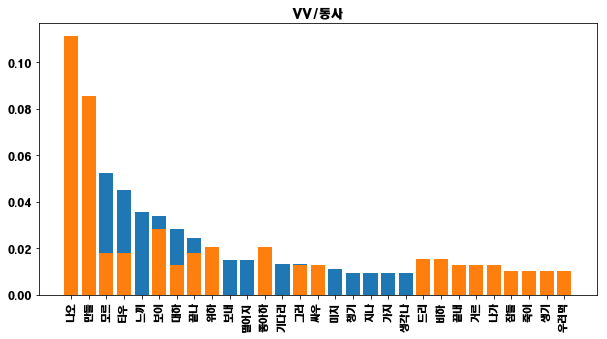

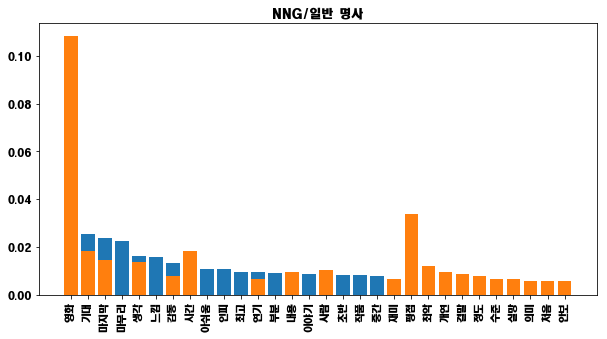

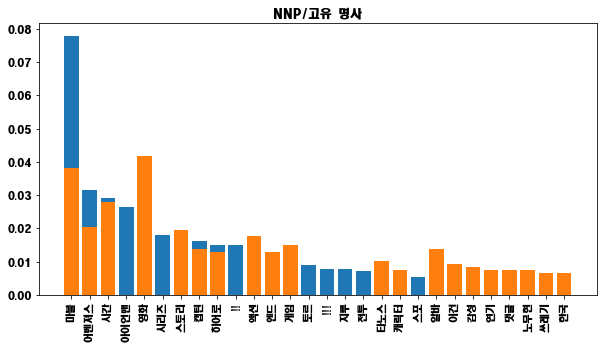

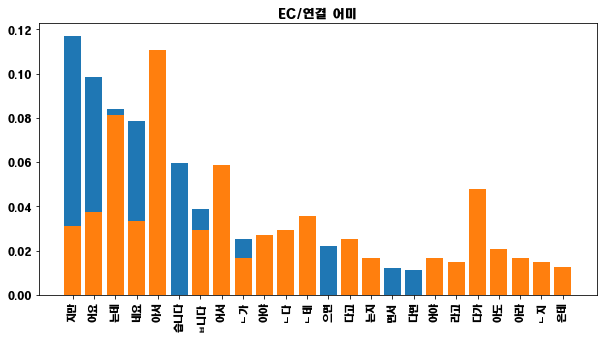

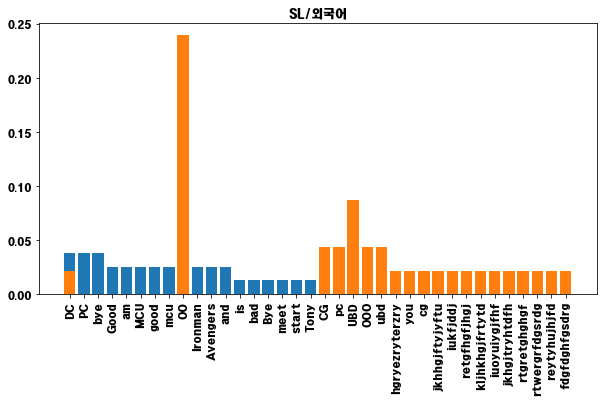

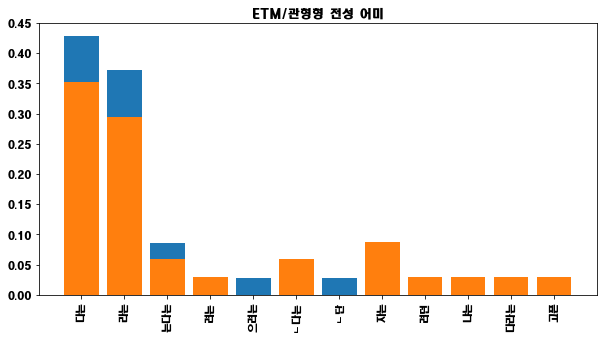

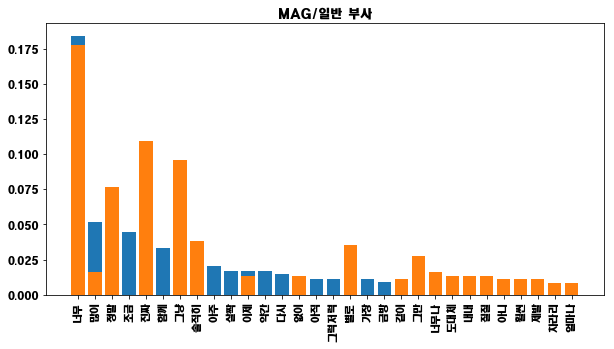

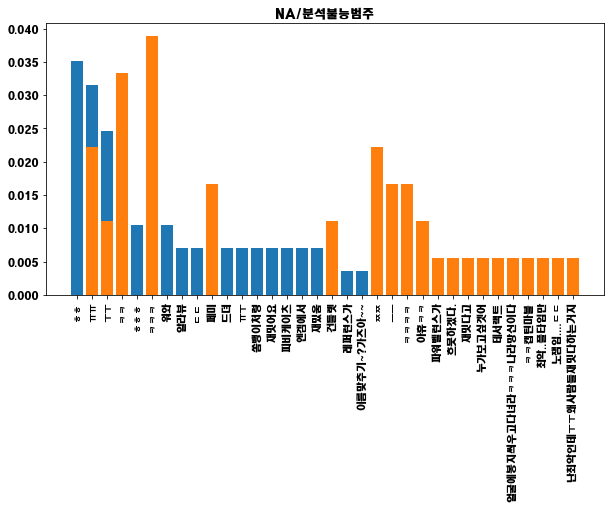

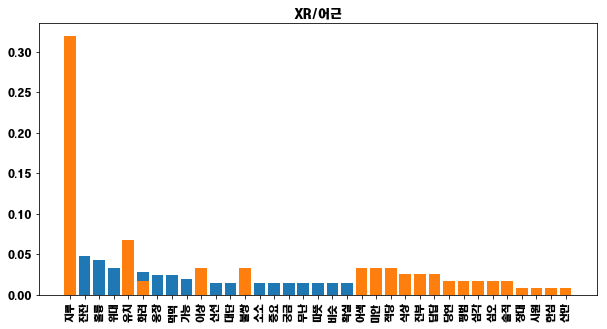

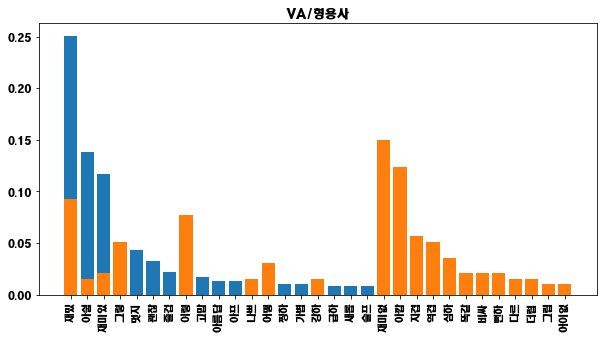

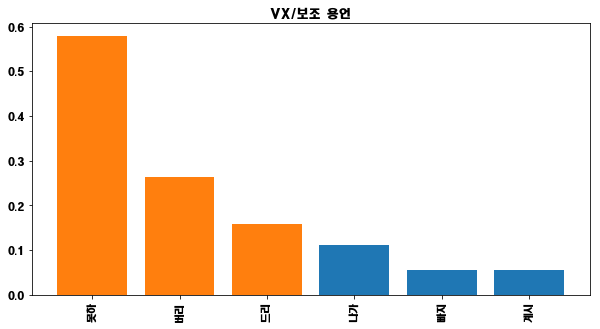

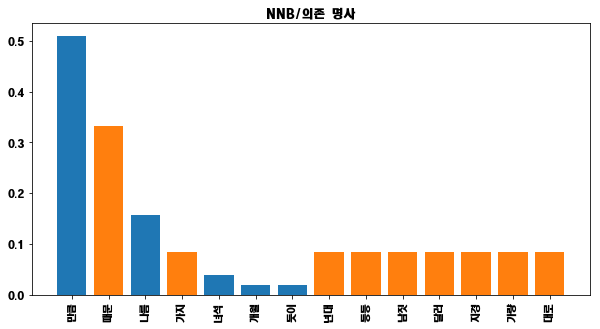

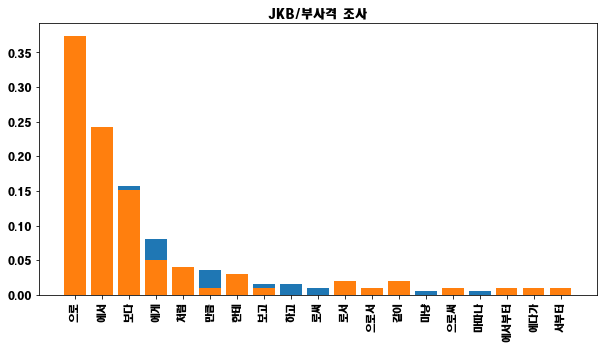

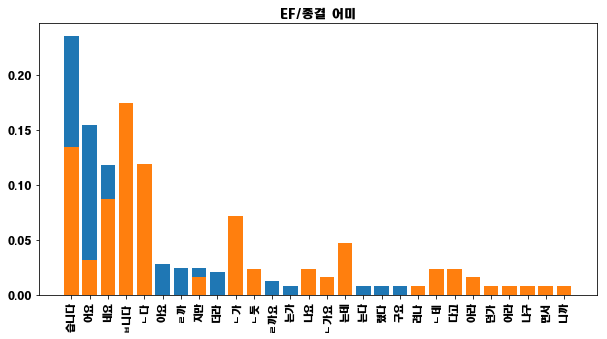

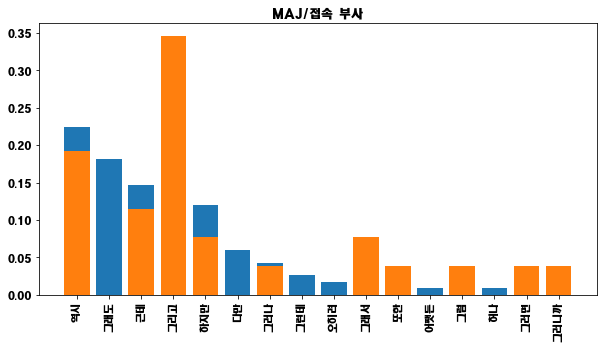

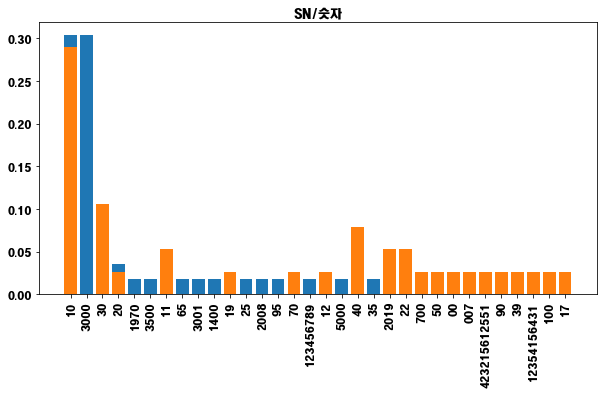

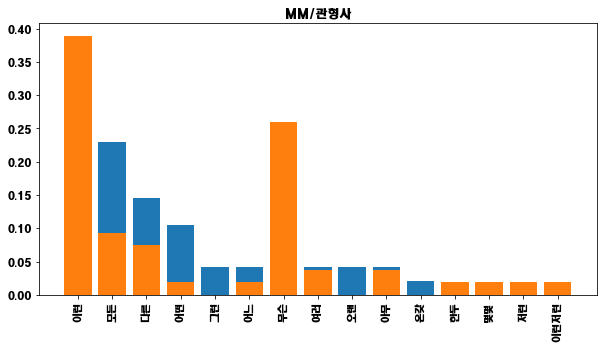

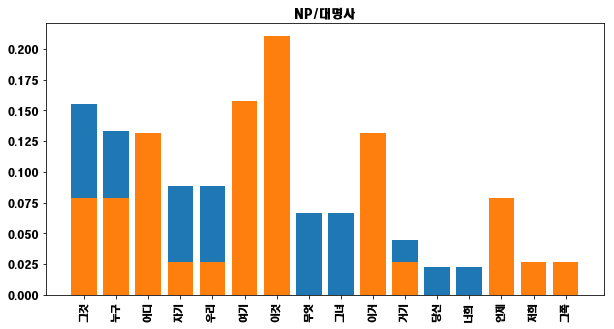

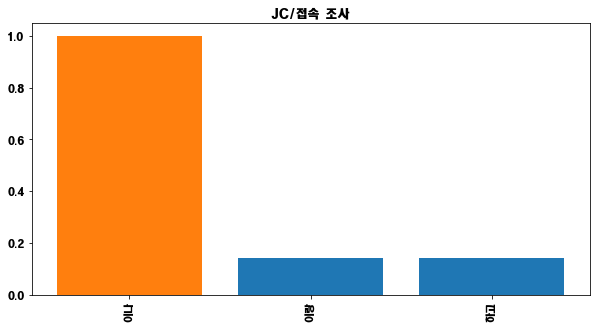

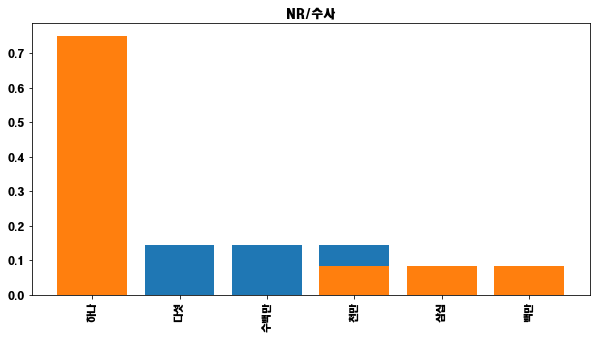

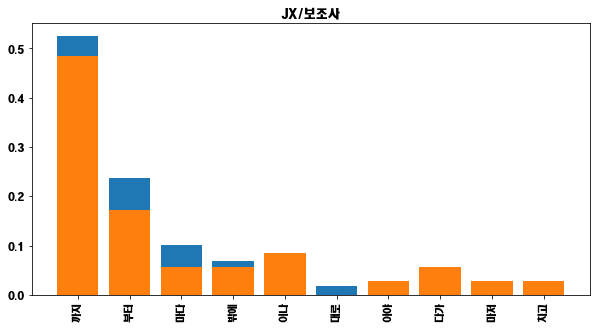

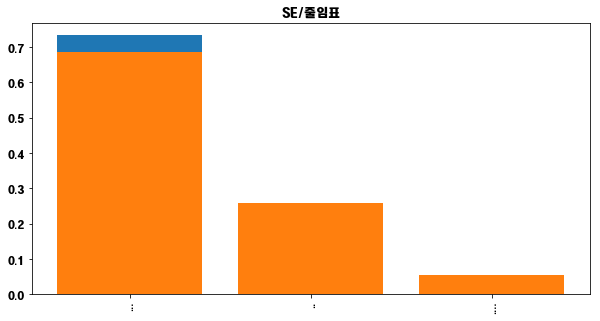

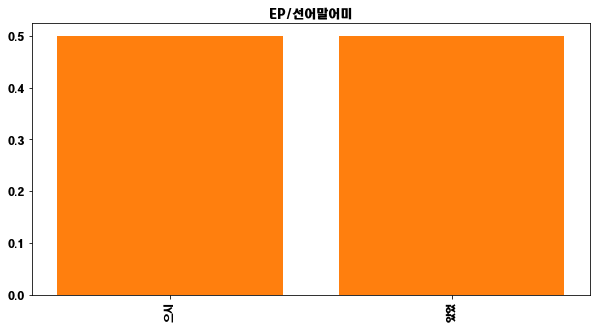

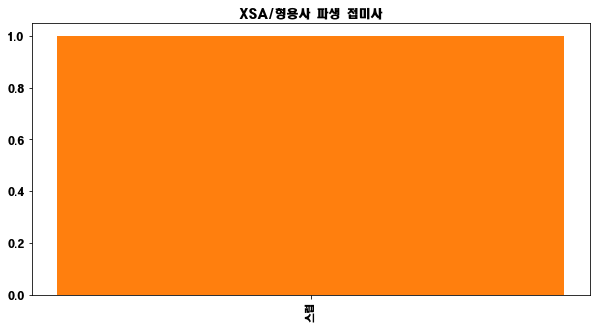

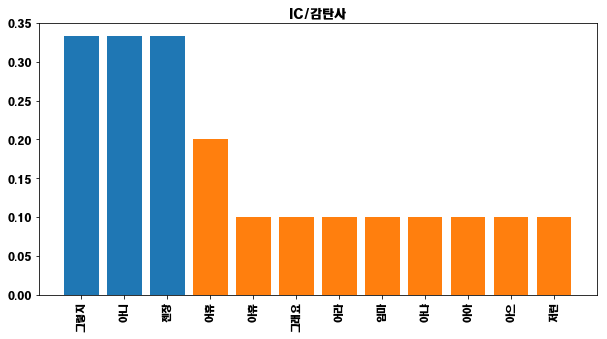

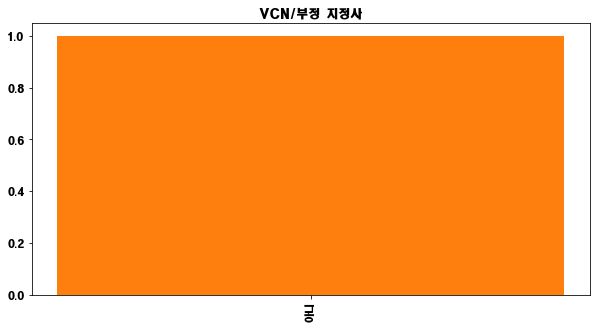

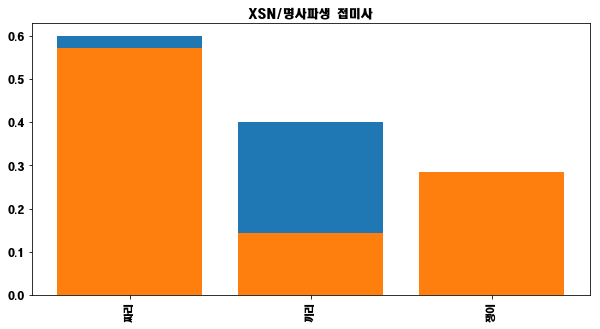

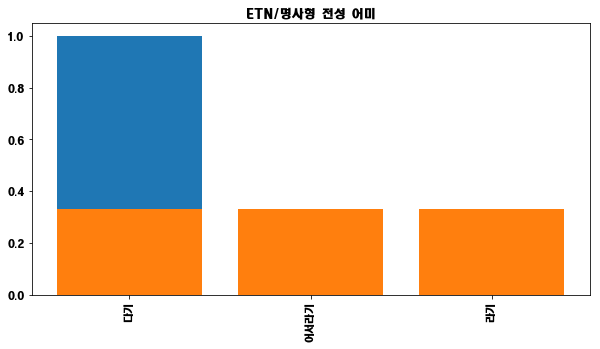

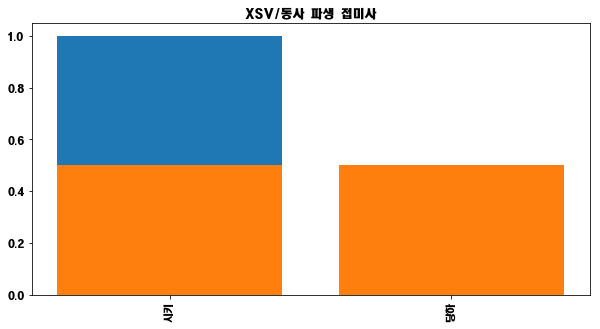

In [19]:
from konlpy.tag import Komoran
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

tagList = Komoran().tagset

path = "C:/windows/fonts/HMKMRHD.ttf"

family = font_manager.FontProperties(fname=path).get_name()
rc("font", family=family)
rc("figure", figsize=(10,5))

for posName in positivePOS.keys():
    pNorm = sum(positivePOS[posName].values())
    pTermList = [pair[0] for pair in positivePOS[posName].most_common()[:20]]
    pFreqList = [pair[1]/pNorm for pair in positivePOS[posName].most_common()[:20]]
    
    nNorm = sum(negativePOS[posName].values())
    nTermList = [pair[0] for pair in negativePOS[posName].most_common()[:20]]
    nFreqList = [pair[1]/nNorm for pair in negativePOS[posName].most_common()[:20]]
    
    plt.title("{0}/{1}".format(posName, tagList[posName]))
    plt.bar(pTermList, pFreqList, align="center")
    plt.bar(nTermList, nFreqList, align="center")
    plt.xticks(rotation=90)
    plt.show()

## PMI & NPMI on Positive and Negative

In [20]:
# PMI 돌리기 -> 두 확률변수의 elements에 대해 상관성을 측정하는 방법
# PMI(x, y)

from math import log

K = 0.1
N = len(positiveDTM) + len(negativeDTM)

positivePMI = defaultdict(float)
positiveNPMI = defaultdict(float)

seedDocList = list(positiveDTM.keys()) # positive 개수
seedLikelihood = len(seedDocList)/N

for term in list(set(positiveLexicon + negativeLexicon)): # positiveLexicon + negativeLexicon는 전체 단어인 셈
    #DF가 몇인지(단어가 몇번 나왔는지)
    termDocList = list(positiveTDM[term].keys()) + list(negativeTDM[term].keys()) # DF에 해당하는 값을 키값으로 가져온 문서들을 합쳤으므로 전체 문서가 된다. 
    termLikelihood = len(termDocList)/N # 수식의 x/N 부분

    jointLikelihood = (len(positiveTDM[term].keys()) + K)/N # Positive 중 term이라는 단어가 나온 문서의 개수 (수식의 분자 부분)
    multiLikelihood = seedLikelihood * termLikelihood

    positivePMI[term] = log(jointLikelihood/multiLikelihood) # 음/양의 상관 관계 파악 목적. -무한대부터 -min값 사이를 가짐. (빈도가 한번밖에 안나오는 경우 -무한대값이 대단히 커지는 문제 발생.)
    positiveNPMI[term] = positivePMI[term]/-log(jointLikelihood) # 바로 윗줄의 문제를 피하기 위해 -1~1로 정규화

In [21]:
# positive계산할때와 비슷하게 계산
negativePMI = defaultdict(float)
negativeNPMI = defaultdict(float)

seedDocList = list(negativeDTM.keys())
seedLikelihood = len(seedDocList)/N

for term in list(set(positiveLexicon + negativeLexicon)):
    termDocList = list(positiveTDM[term].keys()) + list(negativeTDM[term].keys())
    termLikelihood = (len(termDocList) + K)/N

    jointLikelihood = (len(negativeTDM[term].keys()) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood

    negativePMI[term] = log(jointLikelihood/multiLikelihood)
    negativeNPMI[term] = negativePMI[term]/-log(jointLikelihood)

In [22]:
pmiSO = defaultdict(float)
invertedPmiSO = defaultdict(float)

npmiSO = defaultdict(float)
invertedNpmiSO = defaultdict(float)

for term in list(set(positiveLexicon + negativeLexicon)):
    pmiSO[term.split('/')[0]] += positivePMI[term] - negativePMI[term]
    invertedPmiSO[term.split('/')[0]] -= positivePMI[term] - negativePMI[term]
    
    npmiSO[term.split('/')[0]] += positiveNPMI[term] - negativeNPMI[term]
    invertedNpmiSO[term.split('/')[0]] -= positiveNPMI[term] - negativeNPMI[term]

In [23]:
print(sorted(pmiSO.items(), key=lambda x:x[1], reverse=True)[:10])
print()
print(sorted(npmiSO.items(), key=lambda x:x[1], reverse=True)[:10])
print()

print(sorted(pmiSO.items(), key=lambda x:x[1], reverse=False)[:10])
print()
print(sorted(npmiSO.items(), key=lambda x:x[1], reverse=False)[:10])

[('완벽', 6.463410380089675), ('3000', 6.385761059060147), ('만큼', 6.190593238373753), ('아들', 6.11520404442852), ('선물', 6.11520404442852), ('만족', 5.96574269851977), ('조금', 5.961145100508609), ('매력', 5.5766042116899275), ('세계관', 5.36563554922961), ('빠지', 5.189860643125593)]

[('만큼', 0.7609961264705314), ('완벽', 0.7349961071182738), ('3000', 0.7317999960024941), ('조금', 0.7276964899764615), ('아들', 0.6935140726459353), ('선물', 0.6935140726459353), ('만족', 0.6759341549363027), ('아쉽', 0.647808760975207), ('아요', 0.6403622276641878), ('매력', 0.6307109641762119)]

[('어라', -9.888827171896658), ('짜증', -8.568193456587908), ('선동', -7.24643761660559), ('망치', -6.958755544153808), ('뇌물', -6.958755544153808), ('ㄴ다고', -6.5532904360456445), ('서로', -6.5532904360456445), ('각본', -6.5532904360456445), ('신고', -6.5532904360456445), ('던가', -5.860143255485699)]

[('어라', -1.1588569190945304), ('짜증', -1.024775190425156), ('선동', -0.8565311994494419), ('망치', -0.8186674703326816), ('뇌물', -0.8186674703326816), ('ㄴ다고', -0.766

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

path = "C:/windows/fonts/HMKMRHD.ttf"

def drawCloud(words):
    wc = WordCloud(font_path=path, max_words=30, background_color="white")
    wc.generate_from_frequencies(words)
    plt.imshow(wc.to_array())
    plt.axis("off")
    plt.show()

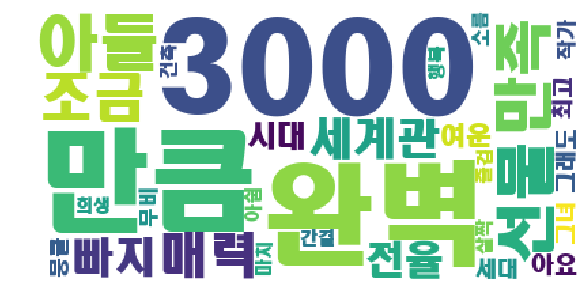

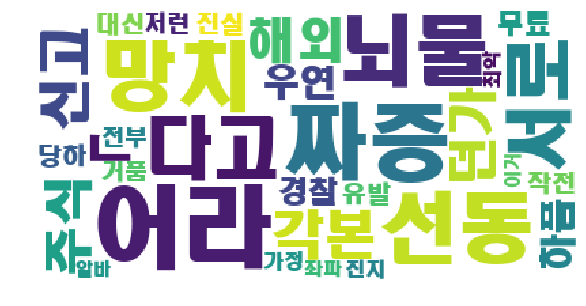

In [25]:
drawCloud(dict(sorted(pmiSO.items(), key=lambda x:x[1], reverse=True)[:30])) # positive
drawCloud(dict(sorted(invertedPmiSO.items(), key=lambda x:x[1], reverse=True)[:30])) # negative

In [26]:
# 새로운 데이터로 돌려보기

# movieReview = "크리스찬 베일의 팬이라 봤는데 연기는 진짜 완벽했다.딕체니만 연구하고 파고든 이유를 충분히 보여줬다.911 이후 우리가 알지 못한 미국의 정치적 이야기가 흥미로웠다.이라크와 아프간 문제를 두고 대립하는 관료들의 설전은 실제로 보는 거처럼 리얼했다."
# movieReview = "영화보고 평점달긴 또 처음이네요...왜 이렇게 눈물이 나는지 모르겠네요ㅠ줄거리보다 마음이 느껴지는 한편의 인생을 보는것 같아요. 강추!!!"
# movieReview = "소리 내 울지 않았던 아버지가 펑펑 우는 그 순간, 영화의 절정이라는 것을 깨달았다. 감동이 휘몰아 치면서 영화에 동화되었다. 하지만 중간에 등장했던 떡밥들이 어중간하게 풀리면서 찜찜함을 남겨주기도 한다."

# movieReview = "말이 필요 없네요 기다린 만큼 재미나게 보고 왔습니다"
# movieReview = "초중반은 지루하고 마지막이 그나마 볼만함마블다른영화보다는 구성이 탄탄하지 않음"
movieReview = "영화라고하기엔;;드라마 스페셜 수준"
# movieReview = "왜 하필 이런 3류영화는 영화 소개부터 꼴통형사로 시작하냐 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ"
# movieReview = "ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 진짜 제목부터 보고싶지않은 영화는 처음이닼ㅋㅋㅋ"

posList = ma.pos(movieReview)
reviewTerms = list()
    
for term in posList:
    if len(term[0]) > 1:
        reviewTerms.append(term[0])

In [27]:
pmiScore = 0.0
npmiScore = 0.0

for term in reviewTerms:
    pmiScore += pmiSO[term]
    npmiScore += npmiSO[term]
    print(term, pmiSO[term], npmiSO[term])
    
if npmiScore > 0.1:
    print("Positive")
elif npmiScore < -0.1:
    print("Negative")
else:
    print("Neutral")

print(pmiScore, npmiScore)

영화 -1.0799701949332916 -0.3538318972876613
라고 -3.8020463253977432 -0.482849943204041
드라마 스페셜 0.0 0.0
수준 -2.6129905804362865 -0.4101397073718055
Negative
-7.495007100767322 -1.2468215478635076


## 시드 단어로 감성분석해보기

In [28]:
pSeeds = ['감동', '재밌', '귀엽', '겁나', '배우', '최고', '따뜻', 'best', '무조건', '와아']
nSeeds = ['실망', '재미없', '슬프', '모르','영화', '평점', '지루', 'but', '너무', '글쎄']

pSeedList = ['재밌/VA', '귀엽/VA', '겁나/VV', '배우/NNP', '최고/NNG', '따뜻/XR', 'best/SL', '무조건/MAG', '와아/IC']
nSeedList = ['재미없/VA', '슬프/VA', '모르/VV', '영화/NNP', '평점/NNG', '지루/XR', 'but/SL', '너무/MAG', '글쎄/IC']

len(pSeedList), len(nSeedList)

(9, 9)

In [29]:
DTM = defaultdict(Counter)

for i, review in enumerate(data['리뷰']):
    posList = ma.morphs(review)
    
    for term in posList: 
        if len(term) > 1:
            DTM[i][term] += 1 

In [30]:
TDM = defaultdict(Counter)

for i, termList in DTM.items():
    for term, freq in termList.items():
        TDM[term][i] = freq

In [31]:
Lexicon = list(TDM.keys())

In [32]:
# 의미를 보려고 하는 것이 아니라 단어 간의 관계를 보고자 하므로 영어 한글 혼용해도 잘 작동. 
# 학습 데이터에 seed 단어가 없다면 빈도가 0이므로 결과가 나오지 않는다. 따라서 seed에 맞게 데이터셋(몇백만 건 이상)을 구축해야 함.
# 이부분부터 html보고 수정(4/24)

from math import log

K = 0.1
N = len(DTM)

pPMI = defaultdict(float)
pNPMI = defaultdict(float)

seedDocList = list(TDM[pSeeds[0]].keys())
seedLikelihood = len(seedDocList)/N

for term in Lexicon:
    termDocList = list(TDM[term].keys())
    termLikelihood = len(termDocList)/N

    jointLikelihood = (len(set(seedDocList).intersection(termDocList)) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood

    pPMI[term] = log(jointLikelihood/multiLikelihood)
    pNPMI[term] = pPMI[term]/-log(jointLikelihood)

In [33]:
nPMI = defaultdict(float)
nNPMI = defaultdict(float)

seedDocList = list(TDM[nSeeds[0]].keys())
seedLikelihood = len(seedDocList) / N

for term in Lexicon:
    termDocList = list(TDM[term].keys())
    termLikelihood = len(termDocList) / N

    jointLikelihood = (len(set(seedDocList).intersection(termDocList)) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood

    nPMI[term] = log(jointLikelihood/multiLikelihood)
    nNPMI[term] = nPMI[term]/-log(jointLikelihood)

In [34]:
SO = defaultdict(float)
iSO = defaultdict(float)

_SO = defaultdict(float)
_iSO = defaultdict(float)

for term in TDM.keys():
    SO[term] += pPMI[term] - nPMI[term]
    iSO[term] -= pPMI[term] - nPMI[term]

    _SO[term] += pNPMI[term] - nNPMI[term]
    _iSO[term] -= pNPMI[term] - nNPMI[term]

In [35]:
print(sorted(SO.items(), key=lambda x:x[1], reverse=True)[:10])
print()
print(sorted(_SO.items(), key=lambda x:x[1], reverse=True)[:10])
print()

print(sorted(SO.items(), key=lambda x:x[1], reverse=False)[:10])
print()
print(sorted(_SO.items(), key=lambda x:x[1], reverse=False)[:10])

[('어요', 3.4828754126764228), ('장면', 3.2646218466564045), ('아쉽', 2.9850369844372433), ('까지', 2.9850369844372433), ('킬링타임', 2.9850369844372433), ('아주', 2.9850369844372433), ('지금', 2.985036984437243), ('ㄴ가', 2.985036984437243), ('감동', 2.6613854362450917), ('아요', 2.59557221767552)]

[('감동', 0.8342744775160345), ('킬링타임', 0.44443947994496213), ('장면', 0.42535955294012995), ('아주', 0.4211378594150465), ('미화', 0.4002927170415485), ('범죄', 0.4002927170415485), ('지금', 0.3905590703078097), ('질질', 0.39044615179569464), ('어요', 0.36509371308127037), ('실화', 0.35985992647945125)]

[('캡틴', -3.8829374245330497), ('지루함', -3.493472657771327), ('평점', -3.4934726577713264), ('결말', -3.4934726577713264), ('루즈', -3.4934726577713264), ('살짝', -3.4934726577713264), ('루소', -3.4934726577713264), ('이후', -3.4934726577713264), ('어도', -3.493472657771326), ('감독', -3.493472657771326)]

[('실망', -0.8347217974852177), ('루소', -0.5228857416232152), ('이후', -0.49229951630697183), ('캡틴', -0.4637096109651624), ('루즈', -0.4617132909907

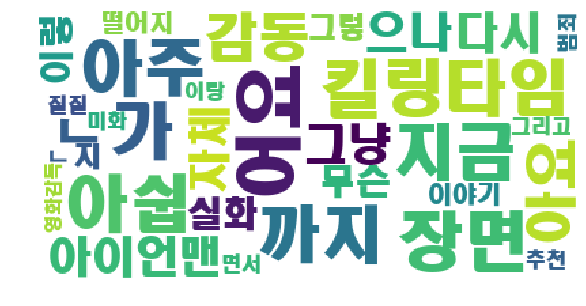

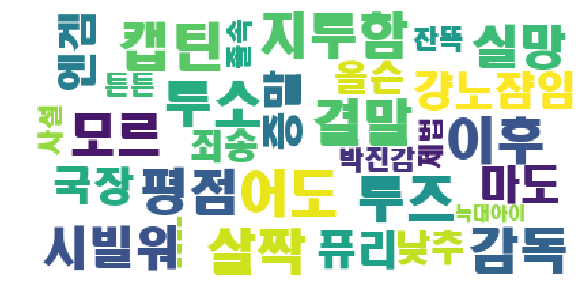

In [36]:
drawCloud(dict(sorted(SO.items(), key=lambda x:x[1], reverse=True)[:30]))
drawCloud(dict(sorted(iSO.items(), key=lambda x:x[1], reverse=True)[:30]))

### 명사만으로 감정 분석해보기

In [37]:
from collections import defaultdict

positiveNouns = defaultdict(list)
negativeNouns = defaultdict(list)

for term in positiveLexicon:
    tokens = term.split('/')
    
    if tokens[1] in ['NNG', 'NNP']:
        positiveNouns[tokens[0]] = list(positiveTDM[term].keys())
    
for term in negativeLexicon:
    tokens = term.split('/')
    
    if tokens[1] in ['NNG', 'NNP']:
        negativeNouns[tokens[0]] = list(negativeTDM[term].keys())

In [38]:
len(positiveNouns), len(negativeNouns)

(1296, 1016)

In [39]:
pSeeds

['감동', '재밌', '귀엽', '겁나', '배우', '최고', '따뜻', 'best', '무조건', '와아']

In [40]:
from math import log

K = 0.1
N = len(positiveDTM) + len(negativeDTM)

positivePMI = defaultdict(float)
positiveNPMI = defaultdict(float)

seedDocList = set(positiveNouns[pSeeds[4]] + negativeNouns[pSeeds[4]])
seedLikelihood = len(seedDocList)/N

for noun in set(list(positiveNouns.keys()) + list(negativeNouns.keys())):
    termDocList = list(positiveNouns[noun] + negativeNouns[noun])
    termLikelihood = (len(termDocList) + K)/N

    jointLikelihood = (len(seedDocList.intersection(termDocList)) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood
    
    positivePMI[noun] = log(jointLikelihood/multiLikelihood)
    positiveNPMI[noun] = positivePMI[noun]/-log(jointLikelihood)

In [41]:
movieReview = '크리스찬 베일의 팬이라 봤는데 연기는 진짜 완벽했다.딕체니만 연구하고 파고든 이유를 충분히 보여줬다.911 이후 우리가 알지 못한 미국의 정치적 이야기가 흥미로웠다.이라크와 아프간 문제를 두고 대립하는 관료들의 설전은 실제로 보는 거처럼 리얼했다.'
# movieReview = '영화보고 평점달긴 또 처음이네요...왜 이렇게 눈물이 나는지 모르겠네요ㅠ줄거리보다 마음이 느껴지는 한편의 인생을 보는것 같아요. 강추!!!'
# movieReview = '소리 내 울지 않았던 아버지가 펑펑 우는 그 순간, 영화의 절정이라는 것을 깨달았다. 감동이 휘몰아 치면서 영화에 동화되었다. 하지만 중간에 등장했던 떡밥들이 어중간하게 풀리면서 찜찜함을 남겨주기도 한다.'
# movieReview = '말이 필요 없네요 기다린 만큼 재미나게 보고 왔습니다'
# movieReview = '초중반은 지루하고 마지막이 그나마 볼만함마블다른영화보다는 구성이 탄탄하지 않음'
# movieReview = '영화라고하기엔;;드라마 스페셜 수준'
# movieReview = '왜 하필 이런 3류영화는 영화 소개부터 꼴통형사로 시작하냐 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ'
# movieReview = 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 진짜 제목부터 보고싶지않은 영화는 처음이닼ㅋㅋㅋ'

posList = ma.pos(movieReview)
reviewTerms = list()
    
for term in posList:
    if len(term[0]) > 1 and term[1] in ['NNG', 'NNP']:
        reviewTerms.append(term[0])

In [42]:
positiveScore = 0.0
negativeScore = 0.0

for term in reviewTerms:
    positiveScore += positivePMI[term]
    negativeScore += negativePMI[term]
    print(term, positivePMI[term], negativePMI[term])
    
if positiveScore - negativeScore > 0:
    print('Positive')
else:
    print('Negative')

print(positiveScore, negativeScore)

크리스찬 베일 0.0 0.0
연기 2.975516973707619 0.0
완벽 0.324571953898966 0.0
체니 0.0 0.0
연구 0.0 0.0
이유 0.4288329642233753 0.0
이후 1.8951700330168024 0.0
미국의 정치 0.0 0.0
이야기 -0.3125809573064045 0.0
흥미 0.8288186065669142 0.0
이라크 0.0 0.0
문제 1.8951700330168024 0.0
대립 0.0 0.0
관료 0.0 0.0
설전 0.0 0.0
리얼 1.0078668380158995 0.0
Positive
9.043366445139975 0.0


In [43]:
K = 0.1
N = len(positiveDTM) + len(negativeDTM)

positivePMI = defaultdict(lambda: defaultdict(float))
positiveNPMI = defaultdict(lambda: defaultdict(float))

for seed in pSeeds[4:6]:
    seedDocList = set(positiveNouns[seed] + negativeNouns[seed])
    seedLikelihood = len(seedDocList)/N

    for noun in set(list(positiveNouns.keys()) + list(negativeNouns.keys())):
        termDocList = list(positiveNouns[noun] + negativeNouns[noun])
        termLikelihood = (len(termDocList) + K)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + K)/N
        multiLikelihood = seedLikelihood * termLikelihood

        positivePMI[seed][noun] = log(jointLikelihood/multiLikelihood)
        positiveNPMI[seed][noun] = positivePMI[seed][noun]/-log(jointLikelihood)

In [44]:
K = 0.1
N = len(positiveDTM) + len(negativeDTM)

negativePMI = defaultdict(lambda: defaultdict(float))
negativeNPMI = defaultdict(lambda: defaultdict(float))

for seed in nSeeds[4:6]:
    seedDocList = set(positiveNouns[seed] + negativeNouns[seed])
    seedLikelihood = len(seedDocList)/N

    for noun in set(list(positiveNouns.keys()) + list(negativeNouns.keys())):
        termDocList = list(positiveNouns[noun] + negativeNouns[noun])
        termLikelihood = (len(termDocList) + K)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + K)/N
        multiLikelihood = seedLikelihood * termLikelihood

        negativePMI[seed][noun] = log(jointLikelihood/multiLikelihood)
        negativeNPMI[seed][noun] = negativePMI[seed][noun]/-log(jointLikelihood)

In [45]:
positiveSO = defaultdict(float)

for noun in set(list(positiveNouns.keys()) + list(negativeNouns.keys())):
    positiveSO[noun] = sum([positivePMI[seed][noun] for seed in pSeeds[4:6]])
    
print(sorted(positiveSO.items(), key=lambda x:x[1], reverse=True)[:10])
print()

positiveSO = defaultdict(float)

for noun in set(list(positiveNouns.keys()) + list(negativeNouns.keys())):
    positiveSO[noun] = sum([positiveNPMI[seed][noun] for seed in pSeeds[4:6]])
    
print(sorted(positiveSO.items(), key=lambda x:x[1], reverse=True)[:10])

[('염정아', 7.848531668499566), ('도가', 7.848531668499566), ('21세기', 6.743890725551301), ('신분', 6.743890725551301), ('동영상', 6.743890725551301), ('용도', 6.743890725551301), ('기념', 6.743890725551301), ('중도', 6.743890725551301), ('정보', 6.743890725551301), ('잭슨', 6.743890725551301)]

[('염정아', 1.0837104211251325), ('도가', 1.0837104211251325), ('배우', 0.9491977118316081), ('최고', 0.9488845190089481), ('잭슨', 0.8692175414466998), ('영화감독', 0.8692175414466998), ('사무엘', 0.8692175414466998), ('이예', 0.8692175414466998), ('오점', 0.8692175414466998), ('박세진', 0.8692175414466998)]


In [46]:
negativeSO = defaultdict(float)

for noun in set(list(positiveNouns.keys()) + list(negativeNouns.keys())):
    negativeSO[noun] = sum([negativePMI[seed][noun] for seed in nSeeds[4:6]])
    
print(sorted(negativeSO.items(), key=lambda x:x[1], reverse=True)[:10])
print()

negativeSO = defaultdict(float)

for noun in set(list(positiveNouns.keys()) + list(negativeNouns.keys())):
    negativeSO[noun] = sum([negativeNPMI[seed][noun] for seed in nSeeds[4:6]])
    
print(sorted(negativeSO.items(), key=lambda x:x[1], reverse=True)[:10])

[('공돈', 5.524160581185824), ('유튜브', 5.524160581185824), ('목표', 5.524160581185824), ('학부모', 5.524160581185824), ('다운', 5.524160581185824), ('형식', 5.524160581185824), ('증명', 5.524160581185824), ('고통', 5.524160581185824), ('여고', 5.524160581185824), ('기자', 5.524160581185824)]

[('평점', 1.1992099569522043), ('영화', 1.163921951601696), ('알바', 0.8417406972928007), ('대부분', 0.8375459957949193), ('공돈', 0.7627656538390735), ('유튜브', 0.7627656538390735), ('목표', 0.7627656538390735), ('학부모', 0.7627656538390735), ('다운', 0.7627656538390735), ('형식', 0.7627656538390735)]


In [47]:
positiveScore = 0.0
negativeScore = 0.0

for term in reviewTerms:
    positiveScore += positiveSO[term]
    negativeScore += negativeSO[term]
    print(term, positiveSO[term], negativeSO[term])
    
if positiveScore - negativeScore > 0:
    print('Positive')
else:
    print('Negative')

print(positiveScore, negativeScore)

크리스찬 베일 0.0 0.0
연기 0.6453896364416224 -0.04808823240898116
완벽 -0.009175669029255977 0.36041175677967513
체니 0.0 0.0
연구 0.0 0.0
이유 0.012454858159903784 -0.029861187420518798
이후 0.31666871275731495 0.23058591316031932
미국의 정치 0.0 0.0
이야기 -0.1413626996996605 -0.005825154150014361
흥미 0.09543794344811422 0.38925942811176095
이라크 0.0 0.0
문제 0.31666871275731495 0.5841955398840271
대립 0.0 0.0
관료 0.0 0.0
설전 0.0 0.0
리얼 0.1325842134341584 0.11799375179521844
Negative
1.3686657082695122 1.5986718157514865


## 형용사로 감성분석하기

In [48]:
positiveAdjectives = defaultdict(list)
negativeAdjectives = defaultdict(list)

for term in positiveLexicon:
    tokens = term.split('/')
    
    if tokens[1] in ['VA']:
        positiveAdjectives[tokens[0]] = list(positiveTDM[term].keys())
    
for term in negativeLexicon:
    tokens = term.split('/')
    
    if tokens[1] in ['VA']:
        negativeAdjectives[tokens[0]] = list(negativeTDM[term].keys())

In [49]:
len(positiveAdjectives), len(negativeAdjectives)

(82, 47)

In [50]:
from math import log

K = 0.1
N = len(positiveDTM) + len(negativeDTM)

positivePMI = defaultdict(float)
positiveNPMI = defaultdict(float)

seedDocList = set(positiveAdjectives[pSeeds[1]] + negativeAdjectives[pSeeds[1]])
seedLikelihood = len(seedDocList)/N

for adj in set(list(positiveAdjectives.keys()) + list(negativeAdjectives.keys())):
    termDocList = list(positiveAdjectives[adj] + negativeAdjectives[adj])
    termLikelihood = (len(termDocList) + K)/N

    jointLikelihood = (len(seedDocList.intersection(termDocList)) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood
    
    positivePMI[adj] = log(jointLikelihood/multiLikelihood)
    positiveNPMI[adj] = positivePMI[adj]/-log(jointLikelihood)

In [51]:
negativePMI = defaultdict(float)
negativeNPMI = defaultdict(float)

seedDocList = set(positiveAdjectives[nSeeds[1]] + negativeAdjectives[nSeeds[1]])
seedLikelihood = len(seedDocList)/N

for adj in set(list(positiveAdjectives.keys()) + list(negativeAdjectives.keys())):
    termDocList = list(positiveAdjectives[adj] + negativeAdjectives[adj])
    termLikelihood = (len(termDocList) + K)/N

    jointLikelihood = (len(seedDocList.intersection(termDocList)) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood
    
    negativePMI[adj] = log(jointLikelihood/multiLikelihood)
    negativeNPMI[adj] = negativePMI[adj]/-log(jointLikelihood)

In [52]:
print(sorted(positivePMI.items(), key=lambda x:x[1], reverse=True)[:10])
print()
print(sorted(positiveNPMI.items(), key=lambda x:x[1], reverse=True)[:10])
print()
print(sorted(negativePMI.items(), key=lambda x:x[1], reverse=True)[:10])
print()
print(sorted(negativeNPMI.items(), key=lambda x:x[1], reverse=True)[:10])

[('귀엽', 2.501305836587118), ('안쓰럽', 2.501305836587118), ('맛있', 2.501305836587118), ('재밌', 2.485569870655303), ('멋있', 2.111841069825395), ('덜하', 1.8546786716620653), ('부럽', 1.8546786716620653), ('이쁘', 1.4652139049003423), ('슬프', 1.1856290426811809), ('급하', 1.1856290426811809)]

[('재밌', 0.9940241730809078), ('귀엽', 0.345375583105571), ('안쓰럽', 0.345375583105571), ('맛있', 0.345375583105571), ('멋있', 0.32018693261951353), ('덜하', 0.2560905261280477), ('부럽', 0.2560905261280477), ('이쁘', 0.20231396711959865), ('슬프', 0.1637094176862569), ('급하', 0.1637094176862569)]

[('낯설', 3.841080182072116), ('용하', 3.841080182072116), ('재미없', 3.841080182072116), ('그럴듯하', 3.841080182072116), ('문제없', 3.194453017147063), ('부럽', 3.194453017147063), ('강하', 3.0123875095159467), ('아프', 2.7747287556222275), ('비싸', 2.5254033881661786), ('그립', 2.3071498221461604)]

[('재미없', 1.0007883475722297), ('낯설', 0.5303690929088851), ('용하', 0.5303690929088851), ('그럴듯하', 0.5303690929088851), ('강하', 0.48538469329060724), ('문제없', 0.44108

In [53]:
movieReview = '엉성한 스토리와 흐름, 뜬금없는 전개들, 이해하기 힘든 필요없는 씬들이 많아 다소 지루하게 다가왔고, 억지스레 집어 넣으려는 개그요소들 때문에 몰입감마저 흐렸다. 특별한 임팩트 없이 지속되다 하이라이트 전투씬이 나왔으나 그마저 기대에 못 미쳤다.'

posList = ma.pos(movieReview)
reviewTerms = list()
    
for term in posList:
    if len(term[0]) > 1 and term[1] in ['VA']:
        reviewTerms.append(term[0])

In [54]:
positiveScore = 0.0
negativeScore = 0.0

for term in reviewTerms:
    positiveScore += positivePMI[term]
    negativeScore += negativePMI[term]
    print(term, positivePMI[term], negativePMI[term])
    
if positiveScore - negativeScore > 0:
    print('Positive')
else:
    print('Negative')

print(positiveScore, negativeScore)

힘들 -1.4305197961372076 2.3071498221461604
흐리 0.0 0.0
Negative
-1.4305197961372076 2.3071498221461604


In [55]:
K = 0.1
N = len(positiveDTM) + len(negativeDTM)

positivePMI = defaultdict(lambda: defaultdict(float))
positiveNPMI = defaultdict(lambda: defaultdict(float))

for seed in pSeeds[1:3]:
    seedDocList = set(positiveAdjectives[seed] + negativeAdjectives[seed])
    seedLikelihood = len(seedDocList)/N

    for adj in set(list(positiveAdjectives.keys()) + list(negativeAdjectives.keys())):
        termDocList = list(positiveAdjectives[adj] + negativeAdjectives[adj])
        termLikelihood = (len(termDocList) + K)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + K)/N
        multiLikelihood = seedLikelihood * termLikelihood

        positivePMI[seed][adj] = log(jointLikelihood/multiLikelihood)
        positiveNPMI[seed][adj] = positivePMI[seed][adj]/-log(jointLikelihood)

In [56]:
K = 0.1
N = len(positiveDTM) + len(negativeDTM)

negativePMI = defaultdict(lambda: defaultdict(float))
negativeNPMI = defaultdict(lambda: defaultdict(float))

for seed in nSeeds[1:3]:
    seedDocList = set(positiveAdjectives[seed] + negativeAdjectives[seed])
    seedLikelihood = len(seedDocList)/N

    for adj in set(list(positiveAdjectives.keys()) + list(negativeAdjectives.keys())):
        termDocList = list(positiveAdjectives[adj] + negativeAdjectives[adj])
        termLikelihood = (len(termDocList) + K)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + K)/N
        multiLikelihood = seedLikelihood * termLikelihood

        negativePMI[seed][adj] = log(jointLikelihood/multiLikelihood)
        negativeNPMI[seed][adj] = negativePMI[seed][adj]/-log(jointLikelihood)

In [57]:
positiveSO = defaultdict(float)

for adj in set(list(positiveAdjectives.keys()) + list(negativeAdjectives.keys())):
    positiveSO[adj] = sum([positivePMI[seed][adj] for seed in pSeeds[1:3]])
    
print(sorted(positiveSO.items(), key=lambda x:x[1], reverse=True)[:10])
print()

positiveSO = defaultdict(float)

for adj in set(list(positiveAdjectives.keys()) + list(negativeAdjectives.keys())):
    positiveSO[adj] = sum([positiveNPMI[seed][adj] for seed in pSeeds[1:3]])
    
print(sorted(positiveSO.items(), key=lambda x:x[1], reverse=True)[:10])

[('귀엽', 9.838893580125713), ('안쓰럽', 7.440998307327344), ('맛있', 7.440998307327344), ('뻔하', 6.412936397375833), ('덜하', 6.147743977477238), ('부럽', 6.147743977477238), ('멋있', 6.015441608878844), ('이쁘', 5.3688144439537915), ('재밌', 5.065656585095535), ('두렵', 5.043103034528973)]

[('귀엽', 1.3585358326217716), ('재밌', 1.350277670925291), ('뻔하', 0.8854861389859776), ('안쓰럽', 0.8577826275125595), ('맛있', 0.8577826275125595), ('멋있', 0.7251174878332403), ('덜하', 0.7014212664178965), ('부럽', 0.7014212664178965), ('이쁘', 0.6072445223333254), ('슬프', 0.5396379138124494)]


In [58]:
negativeSO = defaultdict(float)

for adj in set(list(positiveAdjectives.keys()) + list(negativeAdjectives.keys())):
    negativeSO[adj] = sum([negativePMI[seed][adj] for seed in nSeeds[1:3]])
    
print(sorted(negativeSO.items(), key=lambda x:x[1], reverse=True)[:10])
print()

negativeSO = defaultdict(float)

for adj in set(list(positiveAdjectives.keys()) + list(negativeAdjectives.keys())):
    negativeSO[adj] = sum([negativeNPMI[seed][adj] for seed in nSeeds[1:3]])
    
print(sorted(negativeSO.items(), key=lambda x:x[1], reverse=True)[:10])

[('낯설', 7.394478291692451), ('용하', 7.394478291692451), ('그럴듯하', 7.394478291692451), ('문제없', 6.101223961842345), ('부럽', 6.101223961842345), ('슬프', 6.078801497786514), ('즐겁', 5.357923076405044), ('두렵', 4.996583018894079), ('느리', 4.996583018894079), ('못나', 4.996583018894079)]

[('슬프', 1.0173931496832418), ('재미없', 1.0162626559244954), ('낯설', 0.8989722465945003), ('용하', 0.8989722465945003), ('그럴듯하', 0.8989722465945003), ('문제없', 0.7426108854998374), ('부럽', 0.7426108854998374), ('즐겁', 0.7398118933241196), ('강하', 0.6605489288298475), ('아프', 0.6116021607280708)]


In [59]:
positiveScore = 0.0
negativeScore = 0.0

for term in reviewTerms:
    positiveScore += positiveSO[term]
    negativeScore += negativeSO[term]
    print(term, positiveSO[term], negativeSO[term])
    
if positiveScore - negativeScore > 0:
    print('Positive')
else:
    print('Negative')

print(positiveScore, negativeScore)

힘들 0.20489698143083437 0.5280514874422799
흐리 0.0 0.0
Negative
0.20489698143083437 0.5280514874422799
